# Марковский процесс принятия решений

#### дедлайн задания: 2 апреля, 23:59 GMT+3

В данной работе рассматриваются методы, разработанные для решения Марковских процессов принятия решений,__M__arkov __D__ecision __P__rocesses, MDP. В самом широком смысле, MDP определяется тем, как он изменяет состояния и как вычисляются награды.

Переход состояний определяется распределением $P(s' |s,a)$ &mdash; насколько вероятно перейти в состояние $s'$, если производится действие $a$ в состоянии $s$. Существует несколько способов определить функцию вознаграждений, однако ради удобства будет использована следующая сигнатура: $r(s,a,s')$.

_Данный ноутбук вдохновлён заданием из курса_ [CS294](https://github.com/berkeleydeeprlcourse/homework/blob/36a0b58261acde756abd55306fbe63df226bf62b/hw2/HW2.ipynb) _от Калифорнийского университета в Беркли_

# Работа выполнена: Макарчук Алексей Б05-903в

Для начала, давайте определим простой MDP, изображённый на рисунке ниже:

<img src="https://upload.wikimedia.org/wikipedia/commons/a/ad/Markov_Decision_Process.svg" width="400px" alt="Diagram by Waldoalvarez via Wikimedia Commons, CC BY-SA 4.0"/>

In [1]:
transition_probs = {
    's0': {
        'a0': {'s0': 0.5, 's2': 0.5},
        'a1': {'s2': 1}
    },
    's1': {
        'a0': {'s0': 0.7, 's1': 0.1, 's2': 0.2},
        'a1': {'s1': 0.95, 's2': 0.05}
    },
    's2': {
        'a0': {'s0': 0.4, 's2': 0.6},
        'a1': {'s0': 0.3, 's1': 0.3, 's2': 0.4}
    }
}
rewards = {
    's1': {'a0': {'s0': +5}},
    's2': {'a1': {'s0': -1}}
}

from mdp import MDP
mdp = MDP(transition_probs, rewards, initial_state='s0')

Теперь можно использовать MDP как и другие среды от Open AI Gym:

In [2]:
print('initial state =', mdp.reset())
next_state, reward, done, info = mdp.step('a1')
print('next_state = %s, reward = %s, done = %s' % (next_state, reward, done))

initial state = s0
next_state = s2, reward = 0.0, done = False


но также есть и другие методы, необходимые для имплементации алгоритма итерацонной оптимизации ценности (Value Iteration)

In [3]:
print("mdp.get_all_states =", mdp.get_all_states())
print("mdp.get_possible_actions('s1') = ", mdp.get_possible_actions('s1'))
print("mdp.get_next_states('s1', 'a0') = ", mdp.get_next_states('s1', 'a0'))
print("mdp.get_reward('s1', 'a0', 's0') = ", mdp.get_reward('s1', 'a0', 's0'))
print("mdp.get_transition_prob('s1', 'a0', 's0') = ",
      mdp.get_transition_prob('s1', 'a0', 's0'))

mdp.get_all_states = ('s0', 's1', 's2')
mdp.get_possible_actions('s1') =  ('a0', 'a1')
mdp.get_next_states('s1', 'a0') =  {'s0': 0.7, 's1': 0.1, 's2': 0.2}
mdp.get_reward('s1', 'a0', 's0') =  5
mdp.get_transition_prob('s1', 'a0', 's0') =  0.7


### Опционально: визуализация MDP

Вы можете визуализировать MDP с помощью функции отрисовки, написанной [neer201](https://github.com/neer201).

Для этого требуется установить graphviz системно и для Python. На Unix-подобных системах (Ubuntu) для этого достатчно выполнить следующие команды:

1. `sudo apt-get install graphviz`
2. `pip install graphviz`
3. перезагрузить этот ноутбук

__Замечание:__ Установка graphviz на некоторые ОС (особенно Windows) может быть нетривиальной. Поэтому можно пропусить данный шаг и использовать стандартную визуализацию.

In [4]:
from mdp import has_graphviz
from IPython.display import display
print("Graphviz доступен:", has_graphviz)

Graphviz доступен: True


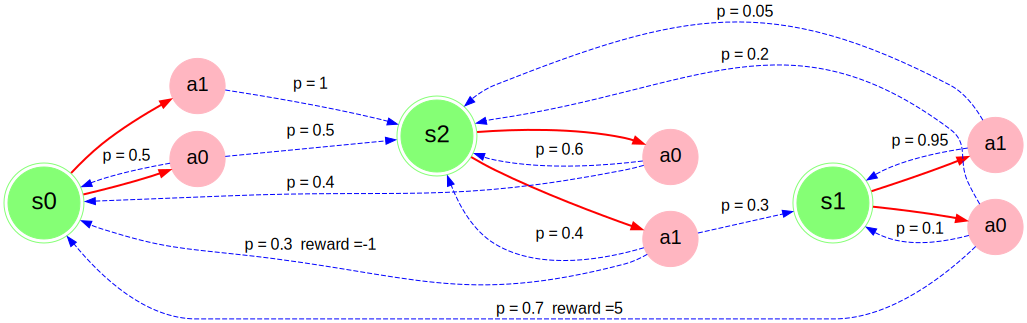

In [5]:
if has_graphviz:
    from mdp import plot_graph, plot_graph_with_state_values, \
        plot_graph_optimal_strategy_and_state_values

    display(plot_graph(mdp))

# Итерационная оптимизация ценности, Value Iteration (вплоть до 4 баллов)

Теперь построим первый способ решения MDP. Простейший на данный момент алгоритм называется итерационной оптимизацией ценности или __V__alue __I__teration

Ниже представлен псевдокод VI:

---

`1.` Инициализация $V^{(0)}(s)=0$, for all $s$

`2.` Для $i=0, 1, 2, \dots$
 
`3.` $ \quad V_{(i+1)}(s) = \max_a \sum_{s'} P(s' | s,a) \cdot [ r(s,a,s') + \gamma V_{i}(s')]$, для всех $s$

---

Для начала выпишем функцию вычисления $Q$-функции ценности $Q^{\pi}$, определив следующим образом

$$Q_i(s, a) = \sum_{s'} P(s' | s,a) \cdot [ r(s,a,s') + \gamma V_{i}(s')]$$


In [6]:
%%writefile mdp_get_action_value.py
def get_action_value(mdp, state_values, state, action, gamma):
    """ Вычисляет Q(s,a) согласно формуле выше """
    
    # Ваша имплементация ниже
    Q = 0
    
    for next_state in mdp.get_next_states(state, action):
        
        transition_prob = mdp.get_transition_prob(state, action, next_state)
        reward = mdp.get_reward(state, action, next_state)
    
        Q += transition_prob * (reward + gamma * state_values[next_state])
    
    return Q

Writing mdp_get_action_value.py


In [7]:
from mdp_get_action_value import *

In [8]:
import numpy as np
test_Vs = {s: i for i, s in enumerate(sorted(mdp.get_all_states()))}
assert np.isclose(get_action_value(mdp, test_Vs, 's2', 'a1', 0.9), 0.69)
assert np.isclose(get_action_value(mdp, test_Vs, 's1', 'a0', 0.9), 3.95)

Используя $Q(s,a)$ можно определить "следующее" $V(s)$ для итерационной оптимизации ценности.
 $$V_{(i+1)}(s) = \max_a \sum_{s'} P(s' | s,a) \cdot [ r(s,a,s') + \gamma V_{i}(s')] = \max_a Q_i(s,a)$$

In [9]:
def get_new_state_value(mdp, state_values, state, gamma):
    """ Вычисляет следующее V(s) согласно формуле выше. Просьба не изменять state_values в процессе. """
    if mdp.is_terminal(state):
        return 0
    
    # Ваша имплементация ниже
    max_Q = float('-inf')
    
    for action in mdp.get_possible_actions(state):
        Q = get_action_value(mdp, state_values, state, action, gamma)
        
        max_Q = max(max_Q, Q)
    
    return max_Q

In [10]:
test_Vs_copy = dict(test_Vs)
assert np.isclose(get_new_state_value(mdp, test_Vs, 's0', 0.9), 1.8)
assert np.isclose(get_new_state_value(mdp, test_Vs, 's2', 0.9), 1.08)
assert test_Vs == test_Vs_copy, "просьба не изменять state_values в get_new_state_value"

Наконец-то можно скомбинировать написанной в работающий алгоритм.

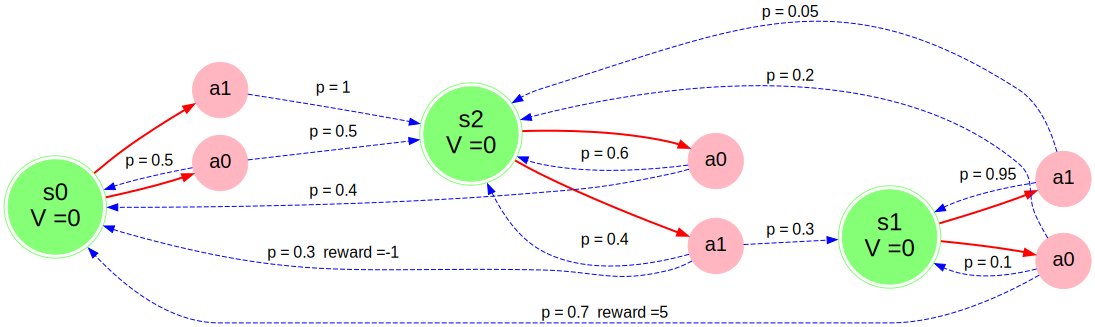

Итерация    0   |   разность max_s|V_new(s) - V_old(s)|: 3.50000   |   V(s0) = 0.000   V(s1) = 0.000   V(s2) = 0.000
Итерация    1   |   разность max_s|V_new(s) - V_old(s)|: 0.64500   |   V(s0) = 0.000   V(s1) = 3.500   V(s2) = 0.000
Итерация    2   |   разность max_s|V_new(s) - V_old(s)|: 0.58050   |   V(s0) = 0.000   V(s1) = 3.815   V(s2) = 0.645
Итерация    3   |   разность max_s|V_new(s) - V_old(s)|: 0.43582   |   V(s0) = 0.581   V(s1) = 3.959   V(s2) = 0.962
Итерация    4   |   разность max_s|V_new(s) - V_old(s)|: 0.30634   |   V(s0) = 0.866   V(s1) = 4.395   V(s2) = 1.272
Итерация    5   |   разность max_s|V_new(s) - V_old(s)|: 0.27571   |   V(s0) = 1.145   V(s1) = 4.670   V(s2) = 1.579
Итерация    6   |   разность max_s|V_new(s) - V_old(s)|: 0.24347   |   V(s0) = 1.421   V(s1) = 4.926   V(s2) = 1.838
Итерация    7   |   разность max_s|V_new(s) - V_old(s)|: 0.21419   |   V(s0) = 1.655   V(s1) = 5.169   V(s2) = 2.075
Итерация    8   |   разность max_s|V_new(s) - V_old(s)|: 0.19277

In [11]:
%%time

# гиперпараметры
gamma = 0.9            # фактор дисконтирования MDP
num_iter = 100         # максимальное количество итераций, не включая инициализацию
# останов VI, если новые значения V(s) настолько близки к старым (или ближе)
min_difference = 0.001

# инициализация V(s)
state_values = {s: 0 for s in mdp.get_all_states()}

if has_graphviz:
    display(plot_graph_with_state_values(mdp, state_values))

for i in range(num_iter):

    # Вычисление новых V(s) используя определённые выше функции.
    # Должен быть словарь {state : float V_new(state)}
    new_state_values = {s: get_new_state_value(mdp, state_values, s, gamma) for s in mdp.get_all_states()}

    assert isinstance(new_state_values, dict)

    # Вычисление темпоральных различий V(s)
    diff = max(abs(new_state_values[s] - state_values[s])
               for s in mdp.get_all_states())
    print("Итерация %4i   |   разность max_s|V_new(s) - V_old(s)|: %6.5f   |   " % (i, diff), end="")
    print('   '.join("V(%s) = %.3f" % (s, v) for s, v in state_values.items()))
    state_values = new_state_values

    if diff < min_difference:
        print("Останов")
        break

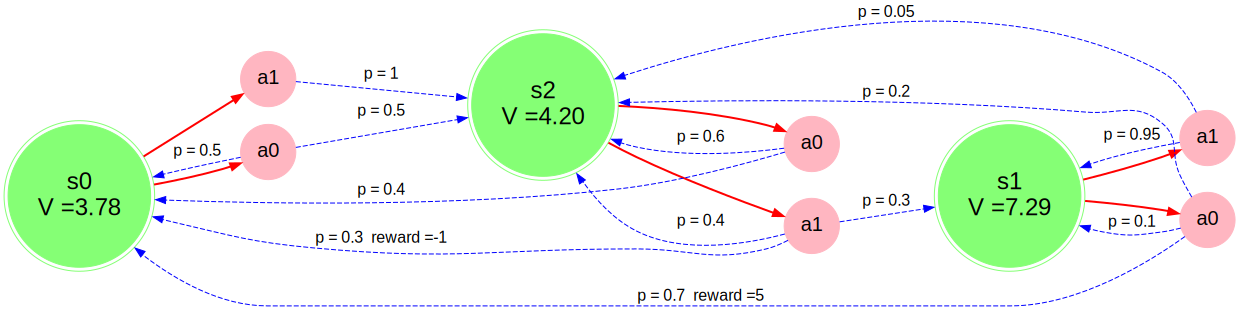

In [12]:
if has_graphviz:
    display(plot_graph_with_state_values(mdp, state_values))

In [13]:
print("Финальные ценности состояний:", state_values)

assert abs(state_values['s0'] - 3.781) < 0.01
assert abs(state_values['s1'] - 7.294) < 0.01
assert abs(state_values['s2'] - 4.202) < 0.01

Финальные ценности состояний: {'s0': 3.7810348735476405, 's1': 7.294006423867229, 's2': 4.202140275227048}


Теперь используем полученные $V^{*}(s)$ для определения оптимальных действий в каждом состоянии

 $$\pi^*(s) = argmax_a \sum_{s'} P(s' | s,a) \cdot [ r(s,a,s') + \gamma V_{i}(s')] = argmax_a Q_i(s,a)$$
 
Единственной отличие по сравнению с вычислением `V(s)` состоит в извлечение не `max`, а `argmax`: поиск действия с максимальной ценностью `Q(s,a)`.

In [14]:
def get_optimal_action(mdp, state_values, state, gamma=0.9):
    """ Выбор оптимального действия, используя формулу выше. """
    if mdp.is_terminal(state):
        return None
    
    optimal_action = None
    max_Q = float('-inf')

    for action in mdp.get_possible_actions(state):
        Q = get_action_value(mdp, state_values, state, action, gamma)

        if Q > max_Q:
            max_Q = Q
            optimal_action = action

    return optimal_action

In [15]:
assert get_optimal_action(mdp, state_values, 's0', gamma) == 'a1'
assert get_optimal_action(mdp, state_values, 's1', gamma) == 'a0'
assert get_optimal_action(mdp, state_values, 's2', gamma) == 'a1'

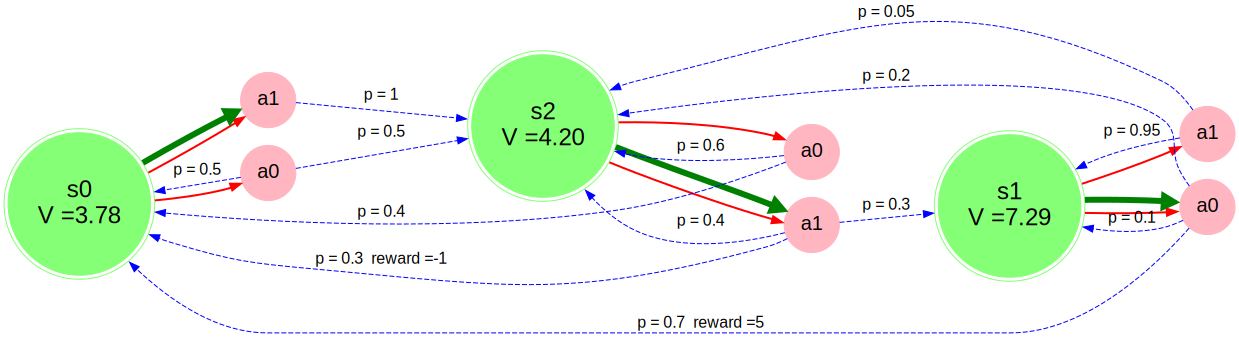

In [16]:
if has_graphviz:
    try:
        display(plot_graph_optimal_strategy_and_state_values(mdp, state_values))
    except ImportError:
        raise ImportError("Запустите ячейку, начинающуюся с \"%%writefile mdp_get_action_value.py\"")

In [17]:
%%time

# Оценка средней награды агента

s = mdp.reset()
rewards = []
for _ in range(10000):
    s, r, done, _ = mdp.step(get_optimal_action(mdp, state_values, s, gamma))
    rewards.append(r)

print("средняя награда: ", np.mean(rewards))

assert(0.40 < np.mean(rewards) < 0.55)

средняя награда:  0.4561
CPU times: user 253 ms, sys: 6.19 ms, total: 259 ms
Wall time: 265 ms


### Frozen lake

In [18]:
from mdp import FrozenLakeEnv
mdp = FrozenLakeEnv(slip_chance=0)

mdp.render()

*FFF
FHFH
FFFH
HFFG



In [19]:
def value_iteration(mdp, state_values=None, gamma=0.9, num_iter=1000, min_difference=1e-5, verbose=True):
    """ Выполняет num_iter шагов итерационной оптимизации ценности, начиная с state_values.
         То же, что и ранее, но в формате функции """
    state_values = state_values or {s: 0 for s in mdp.get_all_states()}
    for i in range(num_iter):

        # Вычислить новые ценности состояний, используя определённые выше функции.
        # В результате должен получиться словарь формата {state : new_V(state)}
        new_state_values = {s: get_new_state_value(mdp, state_values, s, gamma) for s in mdp.get_all_states()}

        assert isinstance(new_state_values, dict)

        # Вычислить темпоральную разность по значениям ценности
        diff = max(abs(new_state_values[s] - state_values[s])
                   for s in mdp.get_all_states())
        
        if verbose:
            print("Итерация %4i   |   разность max_s|V_new(s) - V_old(s)|: %6.5f   |   V(start): %.3f " %
                  (i, diff, new_state_values[mdp._initial_state]))

        state_values = new_state_values
        if diff < min_difference:
            break

    return state_values

In [20]:
%%time

state_values = value_iteration(mdp)

Итерация    0   |   разность max_s|V_new(s) - V_old(s)|: 1.00000   |   V(start): 0.000 
Итерация    1   |   разность max_s|V_new(s) - V_old(s)|: 0.90000   |   V(start): 0.000 
Итерация    2   |   разность max_s|V_new(s) - V_old(s)|: 0.81000   |   V(start): 0.000 
Итерация    3   |   разность max_s|V_new(s) - V_old(s)|: 0.72900   |   V(start): 0.000 
Итерация    4   |   разность max_s|V_new(s) - V_old(s)|: 0.65610   |   V(start): 0.000 
Итерация    5   |   разность max_s|V_new(s) - V_old(s)|: 0.59049   |   V(start): 0.590 
Итерация    6   |   разность max_s|V_new(s) - V_old(s)|: 0.00000   |   V(start): 0.590 
CPU times: user 2.98 ms, sys: 300 µs, total: 3.28 ms
Wall time: 3.27 ms


In [21]:
%%time

s = mdp.reset()
mdp.render()
for t in range(100):
    a = get_optimal_action(mdp, state_values, s, gamma)
    print(a, end='\n\n')
    s, r, done, _ = mdp.step(a)
    mdp.render()
    if done:
        break

*FFF
FHFH
FFFH
HFFG

down

SFFF
*HFH
FFFH
HFFG

down

SFFF
FHFH
*FFH
HFFG

right

SFFF
FHFH
F*FH
HFFG

down

SFFF
FHFH
FFFH
H*FG

right

SFFF
FHFH
FFFH
HF*G

right

SFFF
FHFH
FFFH
HFF*

CPU times: user 2.6 ms, sys: 1.41 ms, total: 4.01 ms
Wall time: 3.81 ms


### Время визуализаций!

Обычно полезно и интересно видеть, что в действительности Ваш алгоритм выучивает под капотом. Для этого можно изобразить V-функцию и оптимальные действия на каждом шаге алгоритма VI.

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline


def draw_policy(mdp, state_values):
    plt.figure(figsize=(3, 3))
    h, w = mdp.desc.shape
    states = sorted(mdp.get_all_states())
    V = np.array([state_values[s] for s in states])
    Pi = {s: get_optimal_action(mdp, state_values, s, gamma) for s in states}
    plt.imshow(V.reshape(w, h), cmap='gray', interpolation='none', clim=(0, 1))
    ax = plt.gca()
    ax.set_xticks(np.arange(h)-.5)
    ax.set_yticks(np.arange(w)-.5)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    Y, X = np.mgrid[0:4, 0:4]
    a2uv = {'left': (-1, 0), 'down': (0, -1), 'right': (1, 0), 'up': (-1, 0)}
    for y in range(h):
        for x in range(w):
            plt.text(x, y, str(mdp.desc[y, x].item()),
                     color='g', size=12,  verticalalignment='center',
                     horizontalalignment='center', fontweight='bold')
            a = Pi[y, x]
            if a is None:
                continue
            u, v = a2uv[a]
            plt.arrow(x, y, u*.3, -v*.3, color='m',
                      head_width=0.1, head_length=0.1)
    plt.grid(color='b', lw=2, ls='-')
    plt.show()

после итерации 0
Итерация    0   |   разность max_s|V_new(s) - V_old(s)|: 1.00000   |   V(start): 0.000 


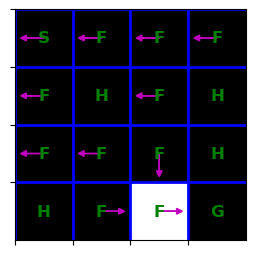

после итерации 1
Итерация    0   |   разность max_s|V_new(s) - V_old(s)|: 0.90000   |   V(start): 0.000 


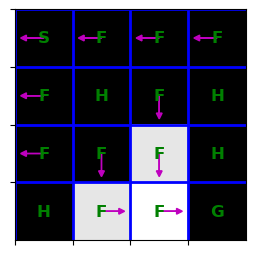

после итерации 2
Итерация    0   |   разность max_s|V_new(s) - V_old(s)|: 0.81000   |   V(start): 0.000 


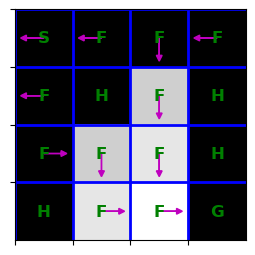

после итерации 3
Итерация    0   |   разность max_s|V_new(s) - V_old(s)|: 0.72900   |   V(start): 0.000 


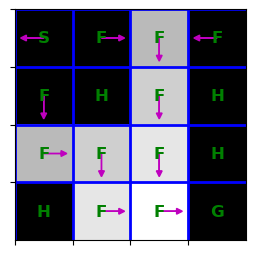

после итерации 4
Итерация    0   |   разность max_s|V_new(s) - V_old(s)|: 0.65610   |   V(start): 0.000 


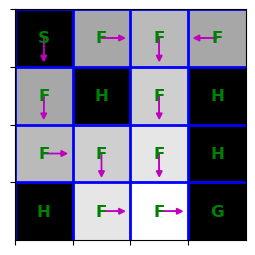

после итерации 5
Итерация    0   |   разность max_s|V_new(s) - V_old(s)|: 0.59049   |   V(start): 0.590 


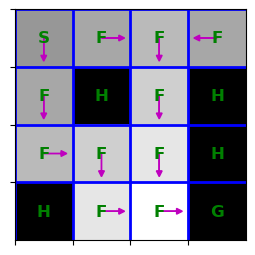

после итерации 6
Итерация    0   |   разность max_s|V_new(s) - V_old(s)|: 0.00000   |   V(start): 0.590 


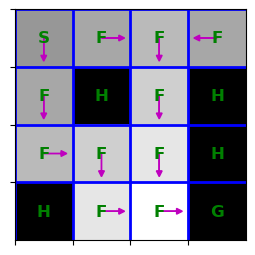

после итерации 7
Итерация    0   |   разность max_s|V_new(s) - V_old(s)|: 0.00000   |   V(start): 0.590 


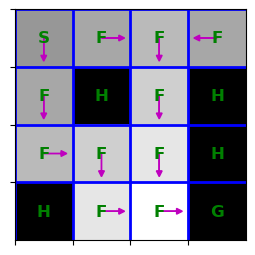

после итерации 8
Итерация    0   |   разность max_s|V_new(s) - V_old(s)|: 0.00000   |   V(start): 0.590 


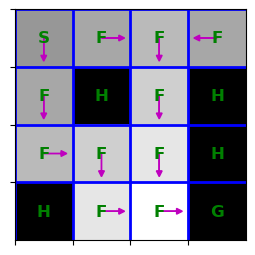

после итерации 9
Итерация    0   |   разность max_s|V_new(s) - V_old(s)|: 0.00000   |   V(start): 0.590 


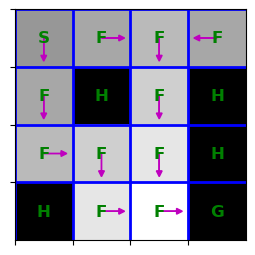

CPU times: user 967 ms, sys: 1.13 s, total: 2.1 s
Wall time: 638 ms


In [23]:
%%time

state_values = {s: 0 for s in mdp.get_all_states()}

for i in range(10):
    print("после итерации %i" % i)
    state_values = value_iteration(mdp, state_values, num_iter=1)
    draw_policy(mdp, state_values)
# просьба игнорировать отладочный вывод "Итерация 0" на каждом шаге

после итерации 29
Итерация    0   |   разность max_s|V_new(s) - V_old(s)|: 0.00000   |   V(start): 0.198 


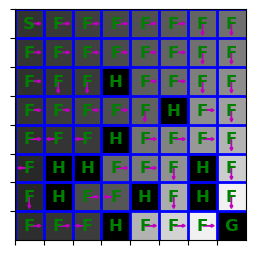

CPU times: user 12.3 s, sys: 8.62 s, total: 21 s
Wall time: 20.2 s


In [24]:
%%time

from IPython.display import clear_output
from time import sleep
mdp = FrozenLakeEnv(map_name='8x8', slip_chance=0.1)
state_values = {s: 0 for s in mdp.get_all_states()}

for i in range(30):
    clear_output(True)
    print("после итерации %i" % i)
    state_values = value_iteration(mdp, state_values, num_iter=1)
    draw_policy(mdp, state_values)
    sleep(0.5)
# просьба игнорировать отладочный вывод "Итерация 0" на каждом шаге

Массовые испытания

In [26]:
%%time

mdp = FrozenLakeEnv(slip_chance=0)
state_values = value_iteration(mdp)

total_rewards = []
for game_i in range(1000):
    s = mdp.reset()
    rewards = []
    for t in range(100):
        s, r, done, _ = mdp.step(
            get_optimal_action(mdp, state_values, s, gamma))
        rewards.append(r)
        if done:
            break
    total_rewards.append(np.sum(rewards))

print("средняя награда: ", np.mean(total_rewards))
assert(1.0 <= np.mean(total_rewards) <= 1.0)
print("Отлинчая работа!")

Итерация    0   |   разность max_s|V_new(s) - V_old(s)|: 1.00000   |   V(start): 0.000 
Итерация    1   |   разность max_s|V_new(s) - V_old(s)|: 0.90000   |   V(start): 0.000 
Итерация    2   |   разность max_s|V_new(s) - V_old(s)|: 0.81000   |   V(start): 0.000 
Итерация    3   |   разность max_s|V_new(s) - V_old(s)|: 0.72900   |   V(start): 0.000 
Итерация    4   |   разность max_s|V_new(s) - V_old(s)|: 0.65610   |   V(start): 0.000 
Итерация    5   |   разность max_s|V_new(s) - V_old(s)|: 0.59049   |   V(start): 0.590 
Итерация    6   |   разность max_s|V_new(s) - V_old(s)|: 0.00000   |   V(start): 0.590 
средняя награда:  1.0
Отлинчая работа!
CPU times: user 189 ms, sys: 15.8 ms, total: 205 ms
Wall time: 190 ms


In [27]:
%%time

# Оценка средней награды агента
mdp = FrozenLakeEnv(slip_chance=0.1)
state_values = value_iteration(mdp)

total_rewards = []
for game_i in range(1000):
    s = mdp.reset()
    rewards = []
    for t in range(100):
        s, r, done, _ = mdp.step(
            get_optimal_action(mdp, state_values, s, gamma))
        rewards.append(r)
        if done:
            break
    total_rewards.append(np.sum(rewards))

print("средняя награда: ", np.mean(total_rewards))
assert(0.8 <= np.mean(total_rewards) <= 0.95)
print("Отличная работа!")

Итерация    0   |   разность max_s|V_new(s) - V_old(s)|: 0.90000   |   V(start): 0.000 
Итерация    1   |   разность max_s|V_new(s) - V_old(s)|: 0.72900   |   V(start): 0.000 
Итерация    2   |   разность max_s|V_new(s) - V_old(s)|: 0.62330   |   V(start): 0.000 
Итерация    3   |   разность max_s|V_new(s) - V_old(s)|: 0.50487   |   V(start): 0.000 
Итерация    4   |   разность max_s|V_new(s) - V_old(s)|: 0.40894   |   V(start): 0.000 
Итерация    5   |   разность max_s|V_new(s) - V_old(s)|: 0.34868   |   V(start): 0.349 
Итерация    6   |   разность max_s|V_new(s) - V_old(s)|: 0.06529   |   V(start): 0.410 
Итерация    7   |   разность max_s|V_new(s) - V_old(s)|: 0.05832   |   V(start): 0.468 
Итерация    8   |   разность max_s|V_new(s) - V_old(s)|: 0.01139   |   V(start): 0.480 
Итерация    9   |   разность max_s|V_new(s) - V_old(s)|: 0.00764   |   V(start): 0.487 
Итерация   10   |   разность max_s|V_new(s) - V_old(s)|: 0.00164   |   V(start): 0.489 
Итерация   11   |   разность max

In [28]:
%%time

# Оценка средней награды агента
mdp = FrozenLakeEnv(slip_chance=0.25)
state_values = value_iteration(mdp)

total_rewards = []
for game_i in range(1000):
    s = mdp.reset()
    rewards = []
    for t in range(100):
        s, r, done, _ = mdp.step(
            get_optimal_action(mdp, state_values, s, gamma))
        rewards.append(r)
        if done:
            break
    total_rewards.append(np.sum(rewards))

print("средняя награда: ", np.mean(total_rewards))
assert(0.6 <= np.mean(total_rewards) <= 0.7)
print("Отличная работа!")

Итерация    0   |   разность max_s|V_new(s) - V_old(s)|: 0.75000   |   V(start): 0.000 
Итерация    1   |   разность max_s|V_new(s) - V_old(s)|: 0.50625   |   V(start): 0.000 
Итерация    2   |   разность max_s|V_new(s) - V_old(s)|: 0.39867   |   V(start): 0.000 
Итерация    3   |   разность max_s|V_new(s) - V_old(s)|: 0.26910   |   V(start): 0.000 
Итерация    4   |   разность max_s|V_new(s) - V_old(s)|: 0.18164   |   V(start): 0.000 
Итерация    5   |   разность max_s|V_new(s) - V_old(s)|: 0.14013   |   V(start): 0.140 
Итерация    6   |   разность max_s|V_new(s) - V_old(s)|: 0.07028   |   V(start): 0.199 
Итерация    7   |   разность max_s|V_new(s) - V_old(s)|: 0.06030   |   V(start): 0.260 
Итерация    8   |   разность max_s|V_new(s) - V_old(s)|: 0.02594   |   V(start): 0.285 
Итерация    9   |   разность max_s|V_new(s) - V_old(s)|: 0.01918   |   V(start): 0.305 
Итерация   10   |   разность max_s|V_new(s) - V_old(s)|: 0.00858   |   V(start): 0.313 
Итерация   11   |   разность max

In [29]:
%%time

# Оценка средней награды агента
mdp = FrozenLakeEnv(slip_chance=0.2, map_name='8x8')
state_values = value_iteration(mdp)

total_rewards = []
for game_i in range(1000):
    s = mdp.reset()
    rewards = []
    for t in range(100):
        s, r, done, _ = mdp.step(
            get_optimal_action(mdp, state_values, s, gamma))
        rewards.append(r)
        if done:
            break
    total_rewards.append(np.sum(rewards))

print("средняя награда: ", np.mean(total_rewards))
assert(0.6 <= np.mean(total_rewards) <= 0.8)
print("Отличная работа!")

Итерация    0   |   разность max_s|V_new(s) - V_old(s)|: 0.80000   |   V(start): 0.000 
Итерация    1   |   разность max_s|V_new(s) - V_old(s)|: 0.57600   |   V(start): 0.000 
Итерация    2   |   разность max_s|V_new(s) - V_old(s)|: 0.41472   |   V(start): 0.000 
Итерация    3   |   разность max_s|V_new(s) - V_old(s)|: 0.29860   |   V(start): 0.000 
Итерация    4   |   разность max_s|V_new(s) - V_old(s)|: 0.24186   |   V(start): 0.000 
Итерация    5   |   разность max_s|V_new(s) - V_old(s)|: 0.19349   |   V(start): 0.000 
Итерация    6   |   разность max_s|V_new(s) - V_old(s)|: 0.15325   |   V(start): 0.000 
Итерация    7   |   разность max_s|V_new(s) - V_old(s)|: 0.12288   |   V(start): 0.000 
Итерация    8   |   разность max_s|V_new(s) - V_old(s)|: 0.09930   |   V(start): 0.000 
Итерация    9   |   разность max_s|V_new(s) - V_old(s)|: 0.08037   |   V(start): 0.000 
Итерация   10   |   разность max_s|V_new(s) - V_old(s)|: 0.06426   |   V(start): 0.000 
Итерация   11   |   разность max

# Итерационная оптимизация политики, Policy Iteration (вплоть до 4 баллов)

Требуется имплементировать явную итерационную оптимизацию политики, Policy Iteration (PI) согласно следующему псевдокоду:

---
Иниуиализация $\pi_0$   `// случайная или константная`

Для $n=0, 1, 2, \dots$
- Вычислить функцию $V^{\pi_{n}}$
- С помощью $V^{\pi_{n}}$, вычислить функцию $Q^{\pi_{n}}$
- Вычислить новую политику $\pi_{n+1}(s) = \operatorname*{argmax}_a Q^{\pi_{n}}(s,a)$
---

В отличие от VI, Policy Iteration требует явное вычисление политики &mdash; выбранное действие для каждого состояния &mdash; и оценку $V^{\pi_{n}}$ на основе данной политики. Обновление политики происходит после (итеративного) вычисления V-функции.


Ниже представлены несколько функций-помощников, которые могут оказаться полезными при имплементации методов.

In [41]:
transition_probs = {
    's0': {
        'a0': {'s0': 0.5, 's2': 0.5},
        'a1': {'s2': 1}
    },
    's1': {
        'a0': {'s0': 0.7, 's1': 0.1, 's2': 0.2},
        'a1': {'s1': 0.95, 's2': 0.05}
    },
    's2': {
        'a0': {'s0': 0.4, 's1': 0.6},
        'a1': {'s0': 0.3, 's1': 0.3, 's2': 0.4}
    }
}
rewards = {
    's1': {'a0': {'s0': +5}},
    's2': {'a1': {'s0': -1}}
}

from mdp import MDP
mdp = MDP(transition_probs, rewards, initial_state='s0')

Настало время написать функцию под названием `compute_vpi`, которая вычисляет функцию $V^{\pi}$ для произвольной политики $\pi$.

В отличие от VI, в этот раз требуется точное решение, не просто одна итерация.

Напоминаем, что $V^{\pi}$ удовлетворяет следующему линейному соотношению:
$$V^{\pi}(s) = \sum_{s'} P(s,\pi(s),s')[ R(s,\pi(s),s') + \gamma V^{\pi}(s')]$$

Вам потребуется решить систему линейных алгебраических уравнений в коде. (Найдите точное решение, например, С помощью `np.linalg.solve` или метода простых итераций.)

In [42]:
import numpy as np

def compute_vpi(mdp, policy, gamma):
    """
    Вычисляет V^pi(s) ДЛЯ ВСЕХ СОСТОЯНИЙ при текущей политике.
    :параметр policy: словарь выбранных на данный момент действий {s : a}
    :возвращает: словарь {state : V^pi(state) для всех state}
    """
    
    A = np.zeros((len(mdp.get_all_states()),len(mdp.get_all_states())))
    b = np.zeros(len(mdp.get_all_states()))
    state_indices = {s: i for i, s in enumerate(mdp.get_all_states())}

    for state in mdp.get_all_states():
        i = state_indices[state]
        if mdp.is_terminal(state):
            A[i, i] = 1
        else:
            action = policy[state]
            for next_state, prob in mdp.get_next_states(state, action).items():
                j = state_indices[next_state]
                reward = mdp.get_reward(state, action, next_state)
                A[i, j] -= gamma * prob
                b[i] += prob * reward

            A[i, i] += 1

    # Решение системы линейных уравнений
    vpi = np.linalg.solve(A, b)

    return {s: vpi[state_indices[s]] for s in mdp.get_all_states()}

In [47]:
%%time

test_policy = {s: np.random.choice(
    mdp.get_possible_actions(s)) for s in mdp.get_all_states()}
new_vpi = compute_vpi(mdp, test_policy, gamma)

print(new_vpi)

assert type(
    new_vpi) is dict, "compute_vpi должен возвращать словарь {state : V^pi(state) для всех state}"

{'s0': 8.031919916894896, 's1': 11.171970913211831, 's2': 8.924355463216552}
CPU times: user 762 µs, sys: 1.19 ms, total: 1.95 ms
Wall time: 1.77 ms


Как только получены нове ценности состояний, время обновить текущую политику.

In [54]:
def compute_new_policy(mdp, vpi, gamma):
    """
    Вычисляет жадно новую политику как argmax по функции ценности
    :параметр vpi: словарь {state : V^pi(state) для всех state}
    :возвращает: словарь {state : оптимальное действие для всех state}
    """
    new_policy = {}
    for state in mdp.get_all_states():
        if mdp.is_terminal(state):
            new_policy[state] = None
        else:
            possible_actions = mdp.get_possible_actions(state)
            action_values = []
            for action in possible_actions:
                v_pi = sum(
                    mdp.get_transition_prob(state, action, next_state) *
                    (mdp.get_reward(state, action, next_state) + gamma * vpi[next_state])
                    for next_state in mdp.get_next_states(state, action)
                )
                action_values.append(v_pi)
                
            new_policy[state] = possible_actions[np.argmax(action_values)]

    return new_policy

In [55]:
%%time

new_policy = compute_new_policy(mdp, new_vpi, gamma)

print(new_policy)

assert type(
    new_policy) is dict, "compute_new_policy должен возвращать словарь {состояние : оптимальное действие}"

{'s0': 'a1', 's1': 'a0', 's2': 'a0'}
CPU times: user 2.55 ms, sys: 3.47 ms, total: 6.03 ms
Wall time: 5.53 ms


__Основной цикл__

In [56]:
def policy_iteration(mdp, policy=None, gamma=0.9, num_iter=1000, min_difference=1e-5):
    """ 
    Запуск итерационной оптимизации политики в цикле на num_iter итераций или пока max_s|V_new(s) - V_old(s)|
    не станет меньше min_difference. Если начальная политика не дана, то инициализация случайная.
    """
    if policy is None:
        policy = {state: np.random.choice(mdp.get_possible_actions(state)) for state in mdp.get_all_states()
                  if not mdp.is_terminal(state)}

    for _ in range(num_iter):
        old_vpi = compute_vpi(mdp, policy, gamma)
        new_policy = compute_new_policy(mdp, old_vpi, gamma)
        new_vpi = compute_vpi(mdp, new_policy, gamma)
        diff = max(abs(new_vpi[state] - old_vpi[state]) for state in mdp.get_all_states())

        if diff < min_difference:
            break

        policy = new_policy

    return new_vpi, policy

__Ваши результаты экспериментирования с PI__

In [77]:
from mdp import FrozenLakeEnv

slip_chances = [0, 0.1, 0.2, 0.3, 0.4, 0.5]
map_names = ["4x4", "8x8"]

for slip_chance in slip_chances:
    for map_name in map_names:
        mdp = FrozenLakeEnv(map_name=map_name, slip_chance=slip_chance)

        print(f"FrozenLakeEnv (slip_chance = {slip_chance}, map_name = {map_name}):")

        # Value Iteration
        state_values_vi  = value_iteration(mdp)
        total_rewards_vi = []
        for game_i in range(1000):
            s = mdp.reset()
            rewards = []
            for t in range(100):
                s, r, done, _ = mdp.step(
                    get_optimal_action(mdp, state_values_vi, s, gamma))
                rewards.append(r)
                if done:
                    break
            total_rewards_vi.append(np.sum(rewards))

        # Policy Iteration
        state_values_pi, policy_pi = policy_iteration(mdp)
        total_rewards_pi = []
        for game_i in range(1000):
            s = mdp.reset()
            rewards = []
            for t in range(100):
                s, r, done, _ = mdp.step(policy_pi[s])
                rewards.append(r)
                if done:
                    break
            total_rewards_pi.append(np.sum(rewards))

        print("Value Iteration среднее:", np.mean(total_rewards_vi))
        print("Policy Iteration среднее:", np.mean(total_rewards_pi))
        print()

FrozenLakeEnv (slip_chance = 0, map_name = 4x4):
Итерация    0   |   разность max_s|V_new(s) - V_old(s)|: 1.00000   |   V(start): 0.000 
Итерация    1   |   разность max_s|V_new(s) - V_old(s)|: 0.90000   |   V(start): 0.000 
Итерация    2   |   разность max_s|V_new(s) - V_old(s)|: 0.81000   |   V(start): 0.000 
Итерация    3   |   разность max_s|V_new(s) - V_old(s)|: 0.72900   |   V(start): 0.000 
Итерация    4   |   разность max_s|V_new(s) - V_old(s)|: 0.65610   |   V(start): 0.000 
Итерация    5   |   разность max_s|V_new(s) - V_old(s)|: 0.59049   |   V(start): 0.590 
Итерация    6   |   разность max_s|V_new(s) - V_old(s)|: 0.00000   |   V(start): 0.590 
Value Iteration среднее: 1.0
Policy Iteration среднее: 1.0

FrozenLakeEnv (slip_chance = 0, map_name = 8x8):
Итерация    0   |   разность max_s|V_new(s) - V_old(s)|: 1.00000   |   V(start): 0.000 
Итерация    1   |   разность max_s|V_new(s) - V_old(s)|: 0.90000   |   V(start): 0.000 
Итерация    2   |   разность max_s|V_new(s) - V_ol

Value Iteration среднее: 0.711
Policy Iteration среднее: 0.746

FrozenLakeEnv (slip_chance = 0.3, map_name = 4x4):
Итерация    0   |   разность max_s|V_new(s) - V_old(s)|: 0.70000   |   V(start): 0.000 
Итерация    1   |   разность max_s|V_new(s) - V_old(s)|: 0.44100   |   V(start): 0.000 
Итерация    2   |   разность max_s|V_new(s) - V_old(s)|: 0.33736   |   V(start): 0.000 
Итерация    3   |   разность max_s|V_new(s) - V_old(s)|: 0.21254   |   V(start): 0.000 
Итерация    4   |   разность max_s|V_new(s) - V_old(s)|: 0.13390   |   V(start): 0.000 
Итерация    5   |   разность max_s|V_new(s) - V_old(s)|: 0.09924   |   V(start): 0.099 
Итерация    6   |   разность max_s|V_new(s) - V_old(s)|: 0.06134   |   V(start): 0.149 
Итерация    7   |   разность max_s|V_new(s) - V_old(s)|: 0.05149   |   V(start): 0.200 
Итерация    8   |   разность max_s|V_new(s) - V_old(s)|: 0.02551   |   V(start): 0.226 
Итерация    9   |   разность max_s|V_new(s) - V_old(s)|: 0.01936   |   V(start): 0.245 
Итера

Value Iteration среднее: 0.404
Policy Iteration среднее: 0.421

FrozenLakeEnv (slip_chance = 0.4, map_name = 8x8):
Итерация    0   |   разность max_s|V_new(s) - V_old(s)|: 0.60000   |   V(start): 0.000 
Итерация    1   |   разность max_s|V_new(s) - V_old(s)|: 0.32400   |   V(start): 0.000 
Итерация    2   |   разность max_s|V_new(s) - V_old(s)|: 0.17496   |   V(start): 0.000 
Итерация    3   |   разность max_s|V_new(s) - V_old(s)|: 0.09448   |   V(start): 0.000 
Итерация    4   |   разность max_s|V_new(s) - V_old(s)|: 0.06802   |   V(start): 0.000 
Итерация    5   |   разность max_s|V_new(s) - V_old(s)|: 0.05204   |   V(start): 0.000 
Итерация    6   |   разность max_s|V_new(s) - V_old(s)|: 0.04463   |   V(start): 0.000 
Итерация    7   |   разность max_s|V_new(s) - V_old(s)|: 0.03600   |   V(start): 0.000 
Итерация    8   |   разность max_s|V_new(s) - V_old(s)|: 0.02940   |   V(start): 0.000 
Итерация    9   |   разность max_s|V_new(s) - V_old(s)|: 0.02308   |   V(start): 0.000 
Итера

Value Iteration среднее: 0.343
Policy Iteration среднее: 0.352



# Поиск MDP, на котором Value Iteration работает достаточно долго (вплоть до 2 баллов)

Когда запускали Value Iteration на небольшой задаче frozen lake, последняя итерация, на которой изменялась стратегия обучаемой политики, была под номером 6 &mdash; то есть Value Iteration находил оптимальную политику на итерации 6. Существуют ли какие-либо гарантии на то, что в общем случае поиск оптимальной политики сверху ограничен конечным числом в MDP с негораниченным горизонтом с дисконтированием? Ответ без дополнительных предположений отрицательный, более того, можно предложить пример MDP, в котором жадный алгоритм оптимизации политики будет работать произвольное наперёд заданное заданное количество итераций.

Ваша задача: предъявить MDP с не более чем 3 состояниями и 2 действиями такой, что на нём алгоритм Value Iteration до останова требует, как минимум, 50 итераций. Используйте фактор дисконтирования, равный 0.95 (Однако, заметим, что величина дисконтирования тут не играет особой роли &mdash; в теории Вы можете предъявить MDP с произвольным дисконтированием, отвечающий требованиям выше.)

Замечание: V-функция ценности должна измениться хотя бы одни раз после 50-ой итерации (включая 50-ую итерацию), не требуется изменение V-функции на каждой итерации.

In [78]:
transition_probs = {
    'A': {
        0: {'B': 1},
        1: {'C': 1},
    },
    'B': {
        0: {'C': 1},
        1: {'A': 1},
    },
    'C': {
        0: {'A': 1},
        1: {'B': 1},
    }
}
rewards = {
    'A': {0: {'B': 0}, 1: {'C': 0}},
    'B': {0: {'C': 0}, 1: {'A': 0}},
    'C': {0: {'A': 100}, 1: {'B': 0}},
}


from mdp import MDP
from numpy import random
mdp = MDP(transition_probs, rewards, initial_state=random.choice(tuple(transition_probs.keys())))
# Не бойтесь изменять начальное состояние initial_state

In [79]:
%%time

gamma = 0.95
state_values = {s: 0 for s in mdp.get_all_states()}
policy = np.array([get_optimal_action(mdp, state_values, state, gamma)
                   for state in sorted(mdp.get_all_states())])

for i in range(100):
    print("после итерации %i" % i)
    state_values = value_iteration(mdp, state_values, num_iter=1, gamma=gamma)

    new_policy = np.array([get_optimal_action(mdp, state_values, state, gamma)
                           for state in sorted(mdp.get_all_states())])

    n_changes = (policy != new_policy).sum()
    print("Количество поменявшихся действий = %i \n" % n_changes)
    policy = new_policy

# просьба игнорировать отладочный вывод "Итерация 0" на каждом шаге

после итерации 0
Итерация    0   |   разность max_s|V_new(s) - V_old(s)|: 100.00000   |   V(start): 0.000 
Количество поменявшихся действий = 1 

после итерации 1
Итерация    0   |   разность max_s|V_new(s) - V_old(s)|: 95.00000   |   V(start): 95.000 
Количество поменявшихся действий = 0 

после итерации 2
Итерация    0   |   разность max_s|V_new(s) - V_old(s)|: 90.25000   |   V(start): 95.000 
Количество поменявшихся действий = 0 

после итерации 3
Итерация    0   |   разность max_s|V_new(s) - V_old(s)|: 85.73750   |   V(start): 180.737 
Количество поменявшихся действий = 0 

после итерации 4
Итерация    0   |   разность max_s|V_new(s) - V_old(s)|: 81.45062   |   V(start): 180.737 
Количество поменявшихся действий = 0 

после итерации 5
Итерация    0   |   разность max_s|V_new(s) - V_old(s)|: 77.37809   |   V(start): 258.116 
Количество поменявшихся действий = 0 

после итерации 6
Итерация    0   |   разность max_s|V_new(s) - V_old(s)|: 73.50919   |   V(start): 258.116 
Количество по